In [1]:
from __future__ import print_function
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras import backend as K
import pandas as pd
from tensorflow.keras import initializers
from tensorflow.keras import layers
from tensorflow.keras import regularizers
import shap
import numpy as np
import matplotlib.pyplot as plt

batch_size = 8192
num_classes = 2
epochs = 20

2022-11-19 16:29:04.616708: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-19 16:29:04.730099: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-19 16:29:04.730118: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-19 16:29:04.750863: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-19 16:29:05.355615: W tensorflow/stream_executor/platform/de

In [2]:
list_m=['xgb','fcnn','lr','dmpnn']
list_f=['AtomPairFP','Charge',
       'MAP4','MOE','MorganFP','Topology']
main_all_feature=pd.DataFrame()
for feature in list_f:
    for m in list_m:
        read_main=pd.read_csv('pred_'+m+'_main_set_'+feature+'.csv')
        df_main=pd.DataFrame(read_main)
        if m=='xgb':
            m='XGB'
        elif m=='fcnn':
            m='FCNN'
        elif m=='lr':
            m='LR'
        elif m=='dmpnn':
            m='D-MPNN'
        pred1=[]
        for p in df_main['pred']:
            if p<=0.5:
                p=0
            else:
                p=1
            pred1.append(p)
        main_all_feature.insert(loc=len(main_all_feature.columns),column=m+'_'+feature,value=pred1)
        

external_all_feature=pd.DataFrame()
for feature in list_f:
    for m in list_m:
        read_main=pd.read_csv('pred_'+m+'_external_set_'+feature+'.csv')
        df_main=pd.DataFrame(read_main)
        if m=='xgb':
            m='XGB'
        elif m=='fcnn':
            m='FCNN'
        elif m=='lr':
            m='LR'
        elif m=='dmpnn':
            m='D-MPNN'
        pred1=[]
        for p in df_main['pred']:
            if p<=0.5:
                p=0
            else:
                p=1
            pred1.append(p)
        external_all_feature.insert(loc=len(external_all_feature.columns),column=m+'_'+feature,value=pred1)

read_m = pd.read_csv("main_set_plus_"+feature+".csv")
df_m = pd.DataFrame(read_m)
a1 = df_m['active']
c1=[]
for b1 in a1:
    if b1==1:
        b1=0
    else:
        b1=1
    c1.append(b1)
#print(a1)
#print(c1)
y_m=pd.DataFrame()
y_m.insert(loc=0, column='active', value=a1)
y_m.insert(loc=1, column='inactive', value=c1)
X_m=main_all_feature
#print(X)

read_e = pd.read_csv("external_set_plus_"+feature+".csv")
df_e = pd.DataFrame(read_e)
a2 = df_e['active']
c1=[]
for b1 in a2:
    if b1==1:
        b1=0
    else:
        b1=1
    c1.append(b1)
#print(a1)
#print(c1)
y_e=pd.DataFrame()
y_e.insert(loc=0, column='active', value=a2)
y_e.insert(loc=1, column='inactive', value=c1)
X_e=external_all_feature

In [3]:
#x.csv contain the information about the fingerprint of compounds,smiles_y.csv contain the information about the classes of compound. They all come from traning set.
#x_validation.csv and smiles_y_validation.csv contain the similar information of x.csv and smiles_y.csv, but they all come from the external validation set.
x_train=X_m
x_test=X_e
y_train=y_m
y_test=y_e
print(y_train)

      active  inactive
0          1         0
1          0         1
2          1         0
3          0         1
4          0         1
...      ...       ...
3457       0         1
3458       1         0
3459       1         0
3460       1         0
3461       1         0

[3462 rows x 2 columns]


In [4]:
#x_train=x_train.iloc[:,0:40]
#x_test=x_test.iloc[:,0:40]
#y_train=y_train.iloc[:,1:3]
#y_test=y_test.iloc[:,1:3]

In [5]:
print(x_train)
print(y_train)

      XGB_AtomPairFP  FCNN_AtomPairFP  LR_AtomPairFP  D-MPNN_AtomPairFP  \
0                  1                1              1                  1   
1                  0                1              0                  0   
2                  0                1              0                  0   
3                  0                1              0                  0   
4                  0                0              0                  0   
...              ...              ...            ...                ...   
3457               0                1              0                  0   
3458               1                1              1                  0   
3459               1                1              1                  1   
3460               1                1              1                  1   
3461               1                1              1                  1   

      XGB_Charge  FCNN_Charge  LR_Charge  D-MPNN_Charge  XGB_MAP4  FCNN_MAP4  \
0              1   

In [6]:
print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (3462, 24)
y_train shape: (3462, 2)
3462 train samples
440 test samples


In [7]:
model = Sequential()
model.add(Dense(800,
                activation='relu',
                input_dim=24,
                kernel_initializer = initializers.RandomNormal(stddev=0.02),
                bias_initializer = initializers.RandomNormal(mean=1.),
                kernel_regularizer = regularizers.l2(1e-1)))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=opt,
              metrics=['AUC'])
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=200,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print(score)
print('Test loss:', score[0])
print('Test AUC:', score[1])

Epoch 1/200


2022-11-19 16:29:07.559080: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-19 16:29:07.559762: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcufft.so.10'; dlerror: libcufft.so.10: cannot open shared object file: No such file or directory
2022-11-19 16:29:07.559837: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcurand.so.10'; dlerror: libcurand.so.10: cannot open shared object file: No such file or directory
2022-11-19 16:29:07.559891: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory
2022-11-19 16:29:07.559944: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could no

1/1 [==============================] - 1s 573ms/step - loss: 1.6267 - auc: 0.6376 - val_loss: 1.3600 - val_auc: 0.9308
Epoch 2/200
1/1 [==============================] - 0s 43ms/step - loss: 1.4614 - auc: 0.8231 - val_loss: 1.4451 - val_auc: 0.9194
Epoch 3/200
1/1 [==============================] - 0s 48ms/step - loss: 1.4741 - auc: 0.8421 - val_loss: 1.3736 - val_auc: 0.9280
Epoch 4/200
1/1 [==============================] - 0s 45ms/step - loss: 1.3835 - auc: 0.8563 - val_loss: 1.2279 - val_auc: 0.9350
Epoch 5/200
1/1 [==============================] - 0s 48ms/step - loss: 1.2434 - auc: 0.8701 - val_loss: 1.0753 - val_auc: 0.9356
Epoch 6/200
1/1 [==============================] - 0s 47ms/step - loss: 1.1473 - auc: 0.8736 - val_loss: 0.9730 - val_auc: 0.9390
Epoch 7/200
1/1 [==============================] - 0s 44ms/step - loss: 1.0651 - auc: 0.8821 - val_loss: 0.9265 - val_auc: 0.9470
Epoch 8/200
1/1 [==============================] - 0s 53ms/step - loss: 1.0514 - auc: 0.8746 - val_lo

Epoch 64/200
1/1 [==============================] - 0s 47ms/step - loss: 0.2494 - auc: 0.9895 - val_loss: 0.4369 - val_auc: 0.9523
Epoch 65/200
1/1 [==============================] - 0s 44ms/step - loss: 0.2480 - auc: 0.9897 - val_loss: 0.4353 - val_auc: 0.9524
Epoch 66/200
1/1 [==============================] - 0s 43ms/step - loss: 0.2450 - auc: 0.9902 - val_loss: 0.4367 - val_auc: 0.9524
Epoch 67/200
1/1 [==============================] - 0s 49ms/step - loss: 0.2569 - auc: 0.9876 - val_loss: 0.4386 - val_auc: 0.9509
Epoch 68/200
1/1 [==============================] - 0s 40ms/step - loss: 0.2386 - auc: 0.9916 - val_loss: 0.4409 - val_auc: 0.9506
Epoch 69/200
1/1 [==============================] - 0s 42ms/step - loss: 0.2344 - auc: 0.9920 - val_loss: 0.4440 - val_auc: 0.9505
Epoch 70/200
1/1 [==============================] - 0s 41ms/step - loss: 0.2344 - auc: 0.9920 - val_loss: 0.4458 - val_auc: 0.9505
Epoch 71/200
1/1 [==============================] - 0s 47ms/step - loss: 0.2494 - a

1/1 [==============================] - 0s 41ms/step - loss: 0.2184 - auc: 0.9921 - val_loss: 0.4424 - val_auc: 0.9506
Epoch 189/200
1/1 [==============================] - 0s 47ms/step - loss: 0.2246 - auc: 0.9914 - val_loss: 0.4438 - val_auc: 0.9501
Epoch 190/200
1/1 [==============================] - 0s 44ms/step - loss: 0.2257 - auc: 0.9905 - val_loss: 0.4408 - val_auc: 0.9506
Epoch 191/200
1/1 [==============================] - 0s 41ms/step - loss: 0.2296 - auc: 0.9907 - val_loss: 0.4347 - val_auc: 0.9508
Epoch 192/200
1/1 [==============================] - 0s 45ms/step - loss: 0.2176 - auc: 0.9922 - val_loss: 0.4299 - val_auc: 0.9513
Epoch 193/200
1/1 [==============================] - 0s 42ms/step - loss: 0.2205 - auc: 0.9922 - val_loss: 0.4273 - val_auc: 0.9513
Epoch 194/200
1/1 [==============================] - 0s 43ms/step - loss: 0.2196 - auc: 0.9917 - val_loss: 0.4279 - val_auc: 0.9514
Epoch 195/200
1/1 [==============================] - 0s 43ms/step - loss: 0.2251 - auc: 0.

In [8]:
# compute SHAP values
explainer = shap.DeepExplainer(model, np.array(x_train))
#shap_values = explainer.shap_values(np.array(x_test))
shap_values = explainer.shap_values(np.array(x_test))

keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


In [9]:
print(type(shap_values))

<class 'list'>


In [10]:
print(np.shape(x_test))

(440, 24)


In [11]:
print(np.shape(shap_values))

(2, 440, 24)


In [12]:
shap_values

[array([[ 0.01850215,  0.00373907,  0.01837395, ...,  0.00039073,
          0.00332857,  0.00099709],
        [ 0.02048915,  0.00413857,  0.0204755 , ...,  0.00044039,
          0.00378945,  0.00111742],
        [ 0.02644485, -0.01109198,  0.02737591, ..., -0.00392942,
         -0.00586327,  0.00157204],
        ...,
        [ 0.01850215,  0.00373907,  0.01837395, ...,  0.00039073,
          0.00332857,  0.00099709],
        [ 0.02211176,  0.00446809,  0.02223375, ...,  0.00048505,
          0.00422122,  0.00122293],
        [ 0.02279607,  0.00460873,  0.02298745, ...,  0.00050562,
          0.00441807,  0.00127042]]),
 array([[-0.01850215, -0.00373907, -0.01837395, ..., -0.00039073,
         -0.00332856, -0.00099709],
        [-0.02048915, -0.00413857, -0.0204755 , ..., -0.00044039,
         -0.00378945, -0.00111742],
        [-0.02644485,  0.01109198, -0.02737591, ...,  0.00392942,
          0.00586327, -0.00157204],
        ...,
        [-0.01850215, -0.00373907, -0.01837395, ..., -

In [13]:
#shap.summary_plot(shap_values,features= x_test,feature_names=x_test.columns,class_names=['non-agonist','agonist'])

In [14]:
#help(shap.summary_plot)

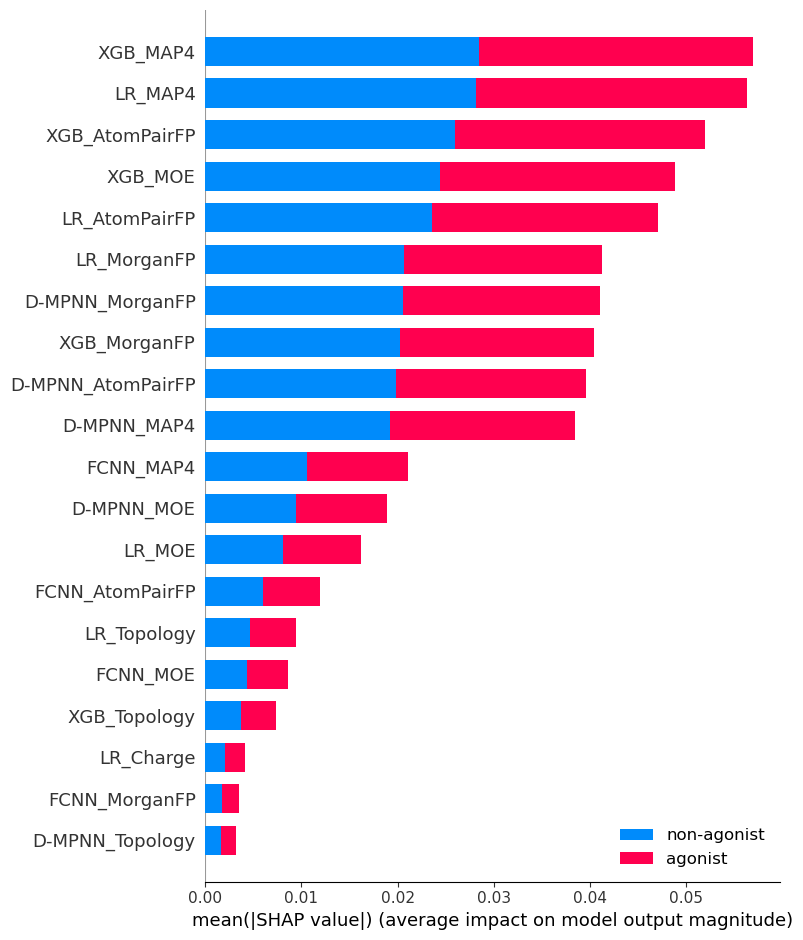

In [17]:
myfig=plt.gcf()
shap.summary_plot(shap_values,features= x_test,feature_names=x_test.columns,class_names=['non-agonist','agonist'], show=False)

In [18]:
myfig.savefig('shap.tif', dpi=600)